In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive
%cd MyDrive
%cd 'KCK projekt'
%cd CardRecognition
!ls 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/KCK projekt
/content/drive/MyDrive/KCK projekt/CardRecognition
app.py	    colors_trained  data	  helper.py	 __pycache__
capture.py  constants.py    data_labeled  preprocess.py  testing.ipynb


In [2]:
import preprocess
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# Testowanie przetwarzania obrazu

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


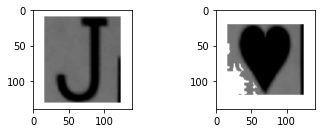

In [3]:
img = cv2.imread('data/40.jpg')
img = cv2.resize(img, (443, 590), interpolation = cv2.INTER_AREA)
value, color = preprocess.get_data(img)
value = value / 255
color = color / 255
plt.subplot(2, 2, 1)
plt.imshow(value, cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(color, cmap='gray')
print(type(value), type(color))

# Wgrywanie danych

In [4]:
values = []
colors = []
values_labels = []
colors_labels = []

for i in os.listdir('data_labeled'):
    if i == 'a-spade.jpg':
      continue
    #parsing
    name, _ = i.split('.')
    v_label, c_label = name.split('-')
    
    #data loading
    img = cv2.imread('data_labeled' + '/' + i)
    img = cv2.resize(img, (443, 590), interpolation = cv2.INTER_AREA)
    value, color = preprocess.get_data(img)
    value = value / 255
    color = color / 255
    
    values.append(value)
    colors.append(color)
    values_labels.append(v_label)
    colors_labels.append(c_label)
    print(v_label, c_label, "LOADED")
    

2 club LOADED
2 diamond LOADED
4 heart LOADED
4 club LOADED
2 spade LOADED
5 diamond LOADED
7 diamond LOADED
8 heart LOADED
9 diamond LOADED
7 club LOADED
5 spade LOADED
6 spade LOADED
10 heart LOADED
9 heart LOADED
8 spade LOADED
5 club LOADED
7 heart LOADED
8 diamond LOADED
7 spade LOADED
10 club LOADED
10 spade LOADED
9 spade LOADED
6 club LOADED
5 heart LOADED
10 diamond LOADED
6 diamond LOADED
6 heart LOADED
2 heart LOADED
8 club LOADED
9 club LOADED
a heart LOADED
k club LOADED
4 diamond LOADED
q heart LOADED
3 heart LOADED
k diamond LOADED
a club LOADED
j club LOADED
j diamond LOADED
j spade LOADED
3 diamond LOADED
4 spade LOADED
j heart LOADED
k heart LOADED
k spade LOADED
q club LOADED
3 spade LOADED
a diamond LOADED
q diamond LOADED
q spade LOADED
3 club LOADED


Przykładowe wgrane obrazki

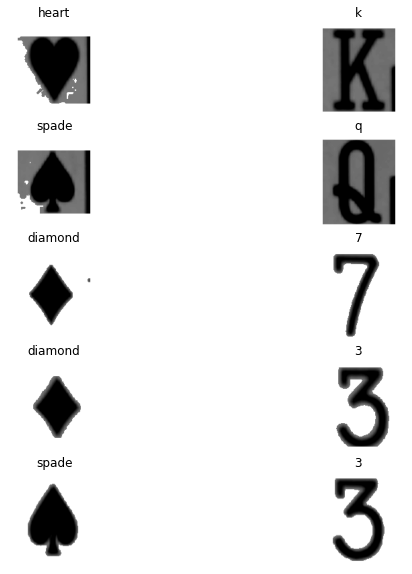

In [5]:
import random
plt.figure(figsize = (10, 10))
for i in [1, 3, 5, 7, 9]:
    card = random.randint(0, 51)
    
    plt.subplot(5, 2, i)
    plt.axis('off')
    plt.title(colors_labels[card])
    plt.imshow(colors[card], cmap = 'gray')
    
    plt.subplot(5, 2, i + 1)
    plt.axis('off')
    plt.title(values_labels[card])
    plt.imshow(values[card], cmap = 'gray')

# Tworzenie sieci neuronowej 

Data augmentation

In [6]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rotation_range = 12,
                         width_shift_range = 0.11,
                         height_shift_range = 0.11,
                         shear_range=0.12,
                         zoom_range = 0.15)

Sprawdzenie działania dla przykładowej karty

In [7]:
def check_data_gen(img):
    img = img.reshape((1, img.shape[0], img.shape[1], 1))
    gen.fit(img)
    gen_iter = gen.flow(img)
    for j in range(10):
        new_img = gen_iter.next()[0]/255
        new_img = new_img.reshape((new_img.shape[0], new_img.shape[1]))
        plt.subplot(5, 5, j+1)
        plt.axis('off')
        plt.imshow(new_img, cmap = 'gray')

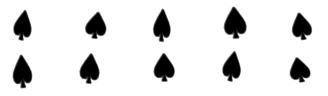

In [8]:
check_data_gen(colors[4])

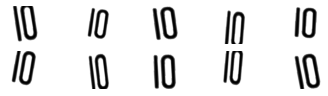

In [9]:
check_data_gen(values[12])

'Dogenerowanie' nowych danych

In [10]:
length = len(values)
for i in range(length):
    img = values[i]
    img = img.reshape((1, img.shape[0], img.shape[1], 1))
    gen.fit(img)
    gen_iter = gen.flow(img)
    for j in range(150):
        new_img = gen_iter.next()[0]/255
        new_img = new_img.reshape((new_img.shape[0], new_img.shape[1]))
        values.append(new_img)
        values_labels.append(values_labels[i])


In [11]:
length = len(colors)
for i in range(length):
    img = colors[i]
    img = img.reshape((1, img.shape[0], img.shape[1], 1))
    gen.fit(img)
    gen_iter = gen.flow(img)
    for j in range(150):
        new_img = gen_iter.next()[0]/255
        new_img = new_img.reshape((new_img.shape[0], new_img.shape[1]))
        colors.append(new_img)
        colors_labels.append(colors_labels[i])

Sprawdzenie

club


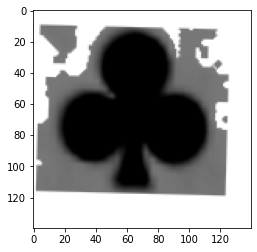

In [12]:
print(colors_labels[100])
plt.imshow(colors[100], cmap = 'gray')

In [13]:
print("Ilosc obrazkow z kolorami", len(colors), len(colors_labels))
print("Ilosc obrazkow z figurami", len(values), len(values_labels))
print("Łącznie:", len(colors) + len(values))

Ilosc obrazkow z kolorami 7701 7701
Ilosc obrazkow z figurami 7701 7701
Łącznie: 15402


# Model neuronowy

Najpierw trzeba zamienić klasy na wartości numeryczne <br>
Dla kolorów: <br>
club - 0 <br>
diamond - 1 <br>
heart - 2 <br>
spade - 3 <br>
Dla wartości: <br>
'2' - 0 <br>
'3' - 1 <br>
'4' - 2 <br>
'5' - 3 <br>
'6' - 4 <br>
'7' - 5 <br>
'8' - 6 <br>
'9'- 7 <br>
'10' - 8 <br>
'A' - 9 <br>
'J' - 10 <br>
'K' - 11 <br>
'Q' - 12 <br>

In [14]:
dict_values = {'2': 0, '3': 1, '4': 2, '5': 3, '6': 4, '7': 5, '8': 6, '9': 7, '10': 8, 'a': 9, 'j': 10, 'k': 11, 'q': 12}
dict_colors = {'club': 0, 'diamond': 1, 'heart': 2, 'spade': 3}

In [15]:
#Before
print(colors_labels[:10])
print(values_labels[:10])

['club', 'diamond', 'heart', 'club', 'spade', 'diamond', 'diamond', 'heart', 'diamond', 'club']
['2', '2', '4', '4', '2', '5', '7', '8', '9', '7']


In [16]:
#After
n_colors_labels = [dict_colors[x] for x in colors_labels]
n_values_labels = [dict_values[x] for x in values_labels]
print(n_colors_labels[:10])
print(n_values_labels[:10])

[0, 1, 2, 0, 3, 1, 1, 2, 1, 0]
[0, 0, 2, 2, 0, 3, 5, 6, 7, 5]


Przygotowanie danych

In [17]:
from sklearn.model_selection import train_test_split
colors = np.array(colors)
values = np.array(values)
n_colors_labels = np.array(n_colors_labels)
n_values_labels = np.array(n_values_labels)

#dla uczenia kolorów
colors_train_x, colors_test_x, colors_train_y, colors_test_y = train_test_split(colors, n_colors_labels, test_size = 0.2)

#dla uczenia wartości
values_train_x, values_test_x, values_train_y, values_test_y = train_test_split(values, n_values_labels, test_size = 0.2)

In [18]:
print('Kolory podzielone z')
print(colors.shape, n_colors_labels.shape)
print('na')
print("Dane treningowe", colors_train_x.shape, colors_train_y.shape)
print("Dane do testowania", colors_test_x.shape, colors_test_y.shape)

print()

print('Wartosci podzielone z')
print(values.shape, n_values_labels.shape)
print('na')
print("Dane treningowe", values_train_x.shape, values_train_y.shape)
print("Dane do testowania", values_test_x.shape, values_test_y.shape)

Kolory podzielone z
(7701, 140, 140) (7701,)
na
Dane treningowe (6160, 140, 140) (6160,)
Dane do testowania (1541, 140, 140) (1541,)

Wartosci podzielone z
(7701, 140, 140) (7701,)
na
Dane treningowe (6160, 140, 140) (6160,)
Dane do testowania (1541, 140, 140) (1541,)


In [19]:
colors_train_x = colors_train_x.reshape((colors_train_x.shape[0], colors_train_x.shape[1], colors_train_x.shape[2], 1))
colors_test_x = colors_test_x.reshape((colors_test_x.shape[0], colors_test_x.shape[1], colors_test_x.shape[2], 1))

values_train_x = values_train_x.reshape((values_train_x.shape[0], values_train_x.shape[1], values_train_x.shape[2], 1))
values_test_x = values_test_x.reshape((values_test_x.shape[0], values_test_x.shape[1], values_test_x.shape[2], 1))

In [20]:
print(colors_train_x.shape, colors_test_x.shape, values_train_x.shape, values_test_x.shape)

(6160, 140, 140, 1) (1541, 140, 140, 1) (6160, 140, 140, 1) (1541, 140, 140, 1)


# Model neuronowy dla kolorów

In [21]:
from tensorflow import keras

model_c = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(colors_train_x.shape[1], colors_train_x.shape[2], colors_train_x.shape[3])),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

In [22]:
model_c.compile(loss = keras.losses.SparseCategoricalCrossentropy(), optimizer='rmsprop', metrics=['accuracy'])

In [23]:
model_c.fit(colors_train_x, colors_train_y, epochs=15, batch_size=16)

Epoch 1/15
385/385 [==============================] - 16s 35ms/step - loss: 1.3903 - accuracy: 0.2568
Epoch 2/15
385/385 [==============================] - 14s 35ms/step - loss: 1.3864 - accuracy: 0.2505
Epoch 3/15
385/385 [==============================] - 14s 35ms/step - loss: 1.3818 - accuracy: 0.2518
Epoch 4/15
385/385 [==============================] - 14s 35ms/step - loss: 0.3565 - accuracy: 0.8521
Epoch 5/15
385/385 [==============================] - 13s 35ms/step - loss: 0.0369 - accuracy: 0.9885
Epoch 6/15
385/385 [==============================] - 14s 35ms/step - loss: 0.0148 - accuracy: 0.9950
Epoch 7/15
385/385 [==============================] - 13s 35ms/step - loss: 0.0098 - accuracy: 0.9977
Epoch 8/15
385/385 [==============================] - 14s 35ms/step - loss: 0.0128 - accuracy: 0.9972
Epoch 9/15
385/385 [==============================] - 13s 35ms/step - loss: 0.0074 - accuracy: 0.9984
Epoch 10/15
385/385 [==============================] - 13s 35ms/step - loss: 0.004

In [25]:
model_c.evaluate(colors_test_x, colors_test_y)

49/49 [==============================] - 2s 25ms/step - loss: 0.0024 - accuracy: 0.9994


[0.0024373307824134827, 0.9993510842323303]

In [26]:
model_c.save("./colors_trained")

INFO:tensorflow:Assets written to: ./colors_trained/assets


In [49]:
model_v = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(values_train_x.shape[1], values_train_x.shape[2], values_train_x.shape[3])),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(13, activation='softmax')
])

In [50]:
model_v.compile(loss = keras.losses.SparseCategoricalCrossentropy(), optimizer='rmsprop', metrics=['accuracy'])

In [51]:
model_v.fit(values_train_x, values_train_y, epochs=15, batch_size=120)

Epoch 1/15
52/52 [==============================] - 11s 186ms/step - loss: 2.5650 - accuracy: 0.0661
Epoch 2/15
52/52 [==============================] - 10s 187ms/step - loss: 2.5643 - accuracy: 0.0812
Epoch 3/15
52/52 [==============================] - 10s 187ms/step - loss: 2.3829 - accuracy: 0.2141
Epoch 4/15
52/52 [==============================] - 10s 187ms/step - loss: 0.9880 - accuracy: 0.6953
Epoch 5/15
52/52 [==============================] - 10s 188ms/step - loss: 0.2628 - accuracy: 0.9216
Epoch 6/15
52/52 [==============================] - 10s 187ms/step - loss: 0.1997 - accuracy: 0.9500
Epoch 7/15
52/52 [==============================] - 10s 188ms/step - loss: 0.1119 - accuracy: 0.9690
Epoch 8/15
52/52 [==============================] - 10s 187ms/step - loss: 0.0450 - accuracy: 0.9867
Epoch 9/15
52/52 [==============================] - 10s 188ms/step - loss: 0.0796 - accuracy: 0.9808
Epoch 10/15
52/52 [==============================] - 10s 187ms/step - loss: 0.0727 - accura

In [54]:
model_v.evaluate(values_test_x, values_test_y)

49/49 [==============================] - 1s 22ms/step - loss: 0.0023 - accuracy: 0.9987


[0.002255921484902501, 0.9987021684646606]

In [55]:
model_v.save("./values_trained")

INFO:tensorflow:Assets written to: ./values_trained/assets


Prezentacja przykładowych wyników

In [65]:
to_values = {0: '2', 1: '3', 2: '4', 3: '5', 4: '6', 5: '7', 6: '8', 7: '9', 8: '10', 9: 'a', 10: 'j', 11: 'k', 12: 'q'}
to_colors = {0: 'club', 1: 'diamond', 2: 'heart', 3: 'spade'}

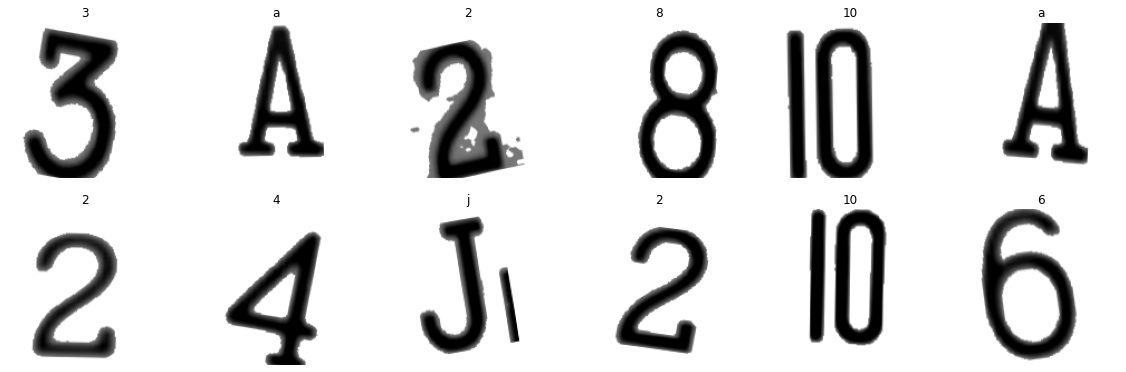

In [69]:
plt.figure(figsize=(20, 20))
for i in range(12):
  x = random.randint(0, 1000)
  plt.subplot(6, 6, i + 1)
  result = model_v.predict(np.array([values_test_x[x]]))
  predicted_value = to_values[np.argmax(result)]
  plt.axis('off')
  plt.title(predicted_value)
  plt.imshow(values_test_x[x][:,:,0], cmap = 'gray')

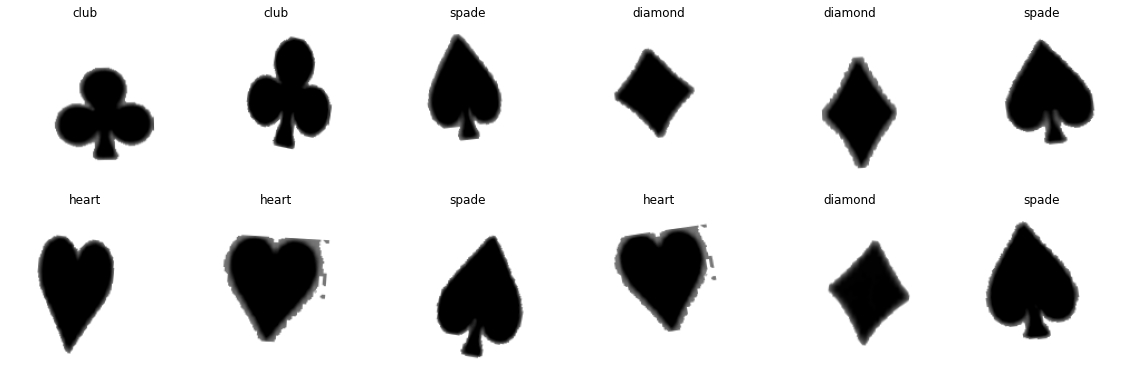

In [71]:
plt.figure(figsize=(20, 20))
for i in range(12):
  x = random.randint(0, 1000)
  plt.subplot(6, 6, i + 1)
  result = model_c.predict(np.array([colors_test_x[x]]))
  predicted_value = to_colors[np.argmax(result)]
  plt.axis('off')
  plt.title(predicted_value)
  plt.imshow(colors_test_x[x][:,:,0], cmap = 'gray')